In [170]:
import numpy as np 
import pandas as pd
from scipy.special import softmax 
import time 
import copy

from copy import deepcopy

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

import sys 
sys.path.append("..") 
from utils.viz import viz 
viz.get_style()

In [171]:
class two_stage:
    nS = 9
    nA = 2
    nC = 2 
    nR = 3
    s_termination = list(range(5,9))
    
    def __init__(self,seed=873):
        '''A MDP is a 5-element-tuple

        S: state space
        A: action space
        T: transition function
        C: certainty
        R: reward condition
        '''
        self.rng = np.random.RandomState(seed)
        self.nS = two_stage.nS
        self.nA = two_stage.nA
        self.nC = two_stage.nC 
        self._init_state()
        self._init_action()
        self._init_trans_fn()
        self._init_reward()


    
    def _init_state(self):
        self.S  = np.arange(two_stage.nS)

    def _init_action(self):
        self.A  = np.arange(two_stage.nA)

    def _init_certainty(self):
        self.C  = np.arange(two_stage.nC)

    def _init_reward(self):
        self.R  = np.arange(two_stage.nR)

    def _init_trans_fn(self):
        '''T(s'|s,a)'''
        def pro(C):
            if C == 0:
                prob = 0.9
            elif C == 1:
                prob = 0.5
            return prob
        
        self.t = {
                0: {0: {0: [0, pro(0), 1-pro(0), 0, 0, 0, 0, 0, 0],
                        1: [0, pro(1), 1-pro(1), 0, 0, 0, 0, 0, 0]},
                    1: {0: [0, 0, 0, pro(0), 1-pro(0), 0, 0, 0, 0],
                        1: [0, 0, 0, pro(1), 1-pro(1), 0, 0, 0, 0]},},

                1: {0: {0: [0, 0, 0, 0, 0, 0, 1-pro(0), pro(0), 0],
                        1: [0, 0, 0, 0, 0, 0, 1-pro(1), pro(1), 0]},
                    1: {0: [0, 0, 0, 0, 0, 1-pro(0), pro(0), 0, 0],
                        1: [0, 0, 0, 0, 0, 1-pro(1), pro(1), 0, 0]},},

                2: {0: {0: [0, 0, 0, 0, 0, 0, 1-pro(0), pro(0), 0],
                        1: [0, 0, 0, 0, 0, 0, 1-pro(1), pro(1), 0]},
                    1: {0: [0, 0, 0, 0, 0, 1-pro(0), 0, pro(0), 0],
                        1: [0, 0, 0, 0, 0, 1-pro(1), 0, pro(1), 0]},},
                
                3: {0: {0: [0, 0, 0, 0, 0, 0, 0, pro(0), 1-pro(0)],
                        1: [0, 0, 0, 0, 0, 0, 0, pro(1), 1-pro(1)]},
                    1: {0: [0, 0, 0, 0, 0, 1-pro(0), 0, 0, pro(0)],
                        1: [0, 0, 0, 0, 0, 1-pro(1), 0, 0, pro(1)]},},

                4: {0: {0: [0, 0, 0, 0, 0, 1-pro(0), 0, pro(0), 0],
                        1: [0, 0, 0, 0, 0, 1-pro(1), 0, pro(1), 0]},
                    1: {0: [0, 0, 0, 0, 0, pro(0), 0, 0, 1-pro(0)],
                        1: [0, 0, 0, 0, 0, pro(1), 0, 0, 1-pro(1)]},},
                }

        
    def trans_fn(self,s,a,C):
        self.T = self.t[s][a][C]
        return self.T         
    
    def _init_reward(self):
        '''R(r|s',a)''' 
    
        self.r = {
                    0:[0,0,0,0,0,0,10,20,40],
                    1:[0,0,0,0,0,0,10,0,0],
                    2:[0,0,0,0,0,0,0,20,0],
                }   
          
    def reward_fn(self,W,s):
        self.R = self.r[W][s]
        return self.R
    
    def reset(self):
        '''always start with state=0
        '''
        self.s = 0
        self.done = False 
        return self.s 
    
    def step(self,a,C,W):
        
        # get next state 
        p_s_next = self.trans_fn(self.s,a,C)
        s_next = self.rng.choice(self.S, p=p_s_next)
        # get the reward
        obj_r = self.reward_fn(W,s_next)
        # check the termination
        if s_next > 4: self.done = True 
        # move on 
        self.s = s_next 

        return self.s, obj_r, self.done

In [172]:
def sim(agent_fn, params, n_episode = 5000, seed=873): 
    # agent_fn = lossarbi specific,high; flexible,low; specific, high; flexible, low
    cols = ['w','Q_mf','Q_mb','r']
    sim_data = {col: [] for col in cols}
    nS, nA= 9, 2 
    rng = np.random.RandomState(seed)
    agent = agent_fn(nS, nA, rng, params=params)
    env = two_stage()
    
    certainty = 0
    goal = 0
    for epi in range(n_episode):

        if epi // 1250 == 0 or epi // 1250 == 2:
            goal = 0
            certainty = 1
        else:
            goal = 1
            certainty = 0
        
        # stage 1
        s1 = env.reset()          # get state 
        a1 = agent.make_move(s1)           # get action
        # stage 2
        s2, r1, done = env.step(a1,C=certainty,W=goal)  # get state; C is the uncertainty, W is the reward condition
        a2 = agent.make_move(s2)           # get action 
        # stage 3
        s3, r2, done = env.step(a2,C=certainty,W=goal)      # get reward
        agent.learn(s1, a1, s2, r1, a2, s3, r2, goal)   
        # save
        sim_data['w'].append(agent.w2)
        sim_data['Q_mf'].append(agent.Q_mf[s2,a2])
        sim_data['Q_mb'].append(agent.Q_mb[s2,a2])  
        sim_data['r'].append(r2)
    
    return sim_data

## The behavior of arbitrator who minimizes loss

In [173]:
from sympy import Q


class lossarbi:
    '''SARSA + Model-based
    '''

    def __init__(self, nS, nA, rng, params):
        self.nS = nS
        self.nA = nA
        self.rng = rng
        self.Q_mf = np.zeros([nS, nA]) 
        self.Q_mb = np.zeros([nS, nA])
        '''
        Agent's perception of the environment, 
        in which he starts with equal probabilities 
        and gradually learn the approximate transition matrix
        '''  
        self.P    = np.zeros([nS, nA, nS])
        self.P[0,0,[1,2]] = .5
        self.P[0,1,[3,4]] = .5
        self.P[1,0,[6,7]] = .5
        self.P[1,1,[5,6]] = .5
        self.P[2,0,[5,6]] = .5
        self.P[2,1,[5,7]] = .5
        self.P[3,0,[7,8]] = .5
        self.P[3,1,[5,8]] = .5
        self.P[4,0,[5,7]] = .5
        self.P[4,1,[5,8]] = .5
        self.P[5:,:,0] = 1
        self.alpha1 = params['alpha1']
        self.alpha2 = params['alpha2']
        self.beta1  = params['beta1']
        self.beta2  = params['beta2']
        self.lmbda  = params['lmbda']
        self.alpha_u = params['alpha_u']
        self.theta1 = params['theta1'] # transition matrix learning rate
        self.p      = params['p']
        self.eta    = params['eta']
        self.u1      = 0
        self.w1      = 1/(1+np.exp(-self.u1)) # arbitration weight for level 1
        self.u2      = 0
        self.w2      = 1/(1+np.exp(-self.u2)) # arbitration weight for level 2
        self.reward = np.zeros([3, nS])
        self.reward[0:,5:] = [[0, 10, 20 ,40],[0,10,0,0],[0,0,20,0]] # should the model based learner learn the reward through trials? 
        #or should we just suppose he knows it immediately
        self.rep_a1  = np.zeros([self.nA])
        self.rep_a2  = np.zeros([self.nA])
  

    def make_move(self, s):
        q_mf = self.Q_mf[s, :]
        q_mb = self.Q_mb[s, :]
        q_net = self.w2*q_mb + (1-self.w2)*q_mf
        beta = self.beta1 if s==0 else self.beta2
        q = q_net + self.p*self.rep_a1 if s==0 else q_net + self.p*self.rep_a2
        pi = softmax(beta*q)
        return self.rng.choice(self.nA, p=pi) 
    
    def learn(self, s1, a1, s2, r1, a2, s3, r2, goal): # r1 = 0, so no use
        #save the Q values
        Q_his_mb = deepcopy(self.Q_mb)
        Q_his_mf = deepcopy(self.Q_mf)
         
        #update the arbitration weight
        w2 = deepcopy(self.w2)
        u2 = deepcopy(self.u2)
        grad_u = (w2*Q_his_mb[s2,a2] + (1-w2)*Q_his_mf[s2,a2] - self.eta*r2) * (Q_his_mb[s2,a2] - Q_his_mf[s2,a2]) * (1/(1+np.exp(-u2))**2) * np.exp(-u2)
        self.u2 = self.u2 - self.alpha_u*grad_u
        self.w2 = 1/(1+np.exp(-self.u2))



        
        
        
        
        #model free update
        q_hat2 = self.Q_mf[s2, a2].copy()
        q_hat1 = self.Q_mf[s1, a1].copy()
        delta2 = r2 - q_hat2
        delta1 = q_hat2 - q_hat1
        # update 
        self.Q_mf[s2, a2] += self.alpha2*delta2
        self.Q_mf[s1, a1] += self.alpha1*(delta1 + self.lmbda*delta2)

        #model based update
        #update the transition matrix
        self.P[s2, a2, s3] = self.P[s2, a2, s3] * (1 - self.theta1) + self.theta1
        for i in range(9):
            if self.P[s2, a2, i] != 0 and i != s3:
                self.P[s2, a2, i] = 1 - self.P[s2, a2, s3].copy() ###then update the Q value for model based learner
                self.Q_mb[s2, a2] = self.P[s2, a2, s3] * self.reward[goal, s3] + self.P[s2, a2, i] * self.reward[goal, i]    

        self.P[s1, a1, s2] = self.P[s1, a1, s2] * (1 - self.theta1) + self.theta1
        if a1 == 0:
            self.P[s1, a1, 3-s2] = 1 - self.P[s1, a1, s2]
            self.Q_mb[s1, a1] = self.P[s1, a1, s2] * np.max(self.Q_mb[s2, :]) + self.P[s1, a1, 3-s2] * np.max(self.Q_mb[3-s2, :])
        else:
            self.P[s1, a1, 7-s2] = 1 - self.P[s1, a1, s2]
            self.Q_mb[s1, a1] = self.P[s1, a1, s2] * np.max(self.Q_mb[s2, :]) + self.P[s1, a1, 7-s2] * np.max(self.Q_mb[7-s2, :])
        
        
        

        # update perseveration
        self.rep_a1 = np.eye(self.nA)[a1]
        self.rep_a2 = np.eye(self.nA)[a2]
       

        

In [174]:
agent_fn = lossarbi
params = {'alpha1': .2,
          'alpha2': .2, 
          'beta1': 6, 
          'beta2': 4, 
          'lmbda': .6,
          'alpha_u': .00005,
          'p': .1,
          'eta':.99,
          'theta1':0.3
          }
sim_LA_data = sim(agent_fn, params)

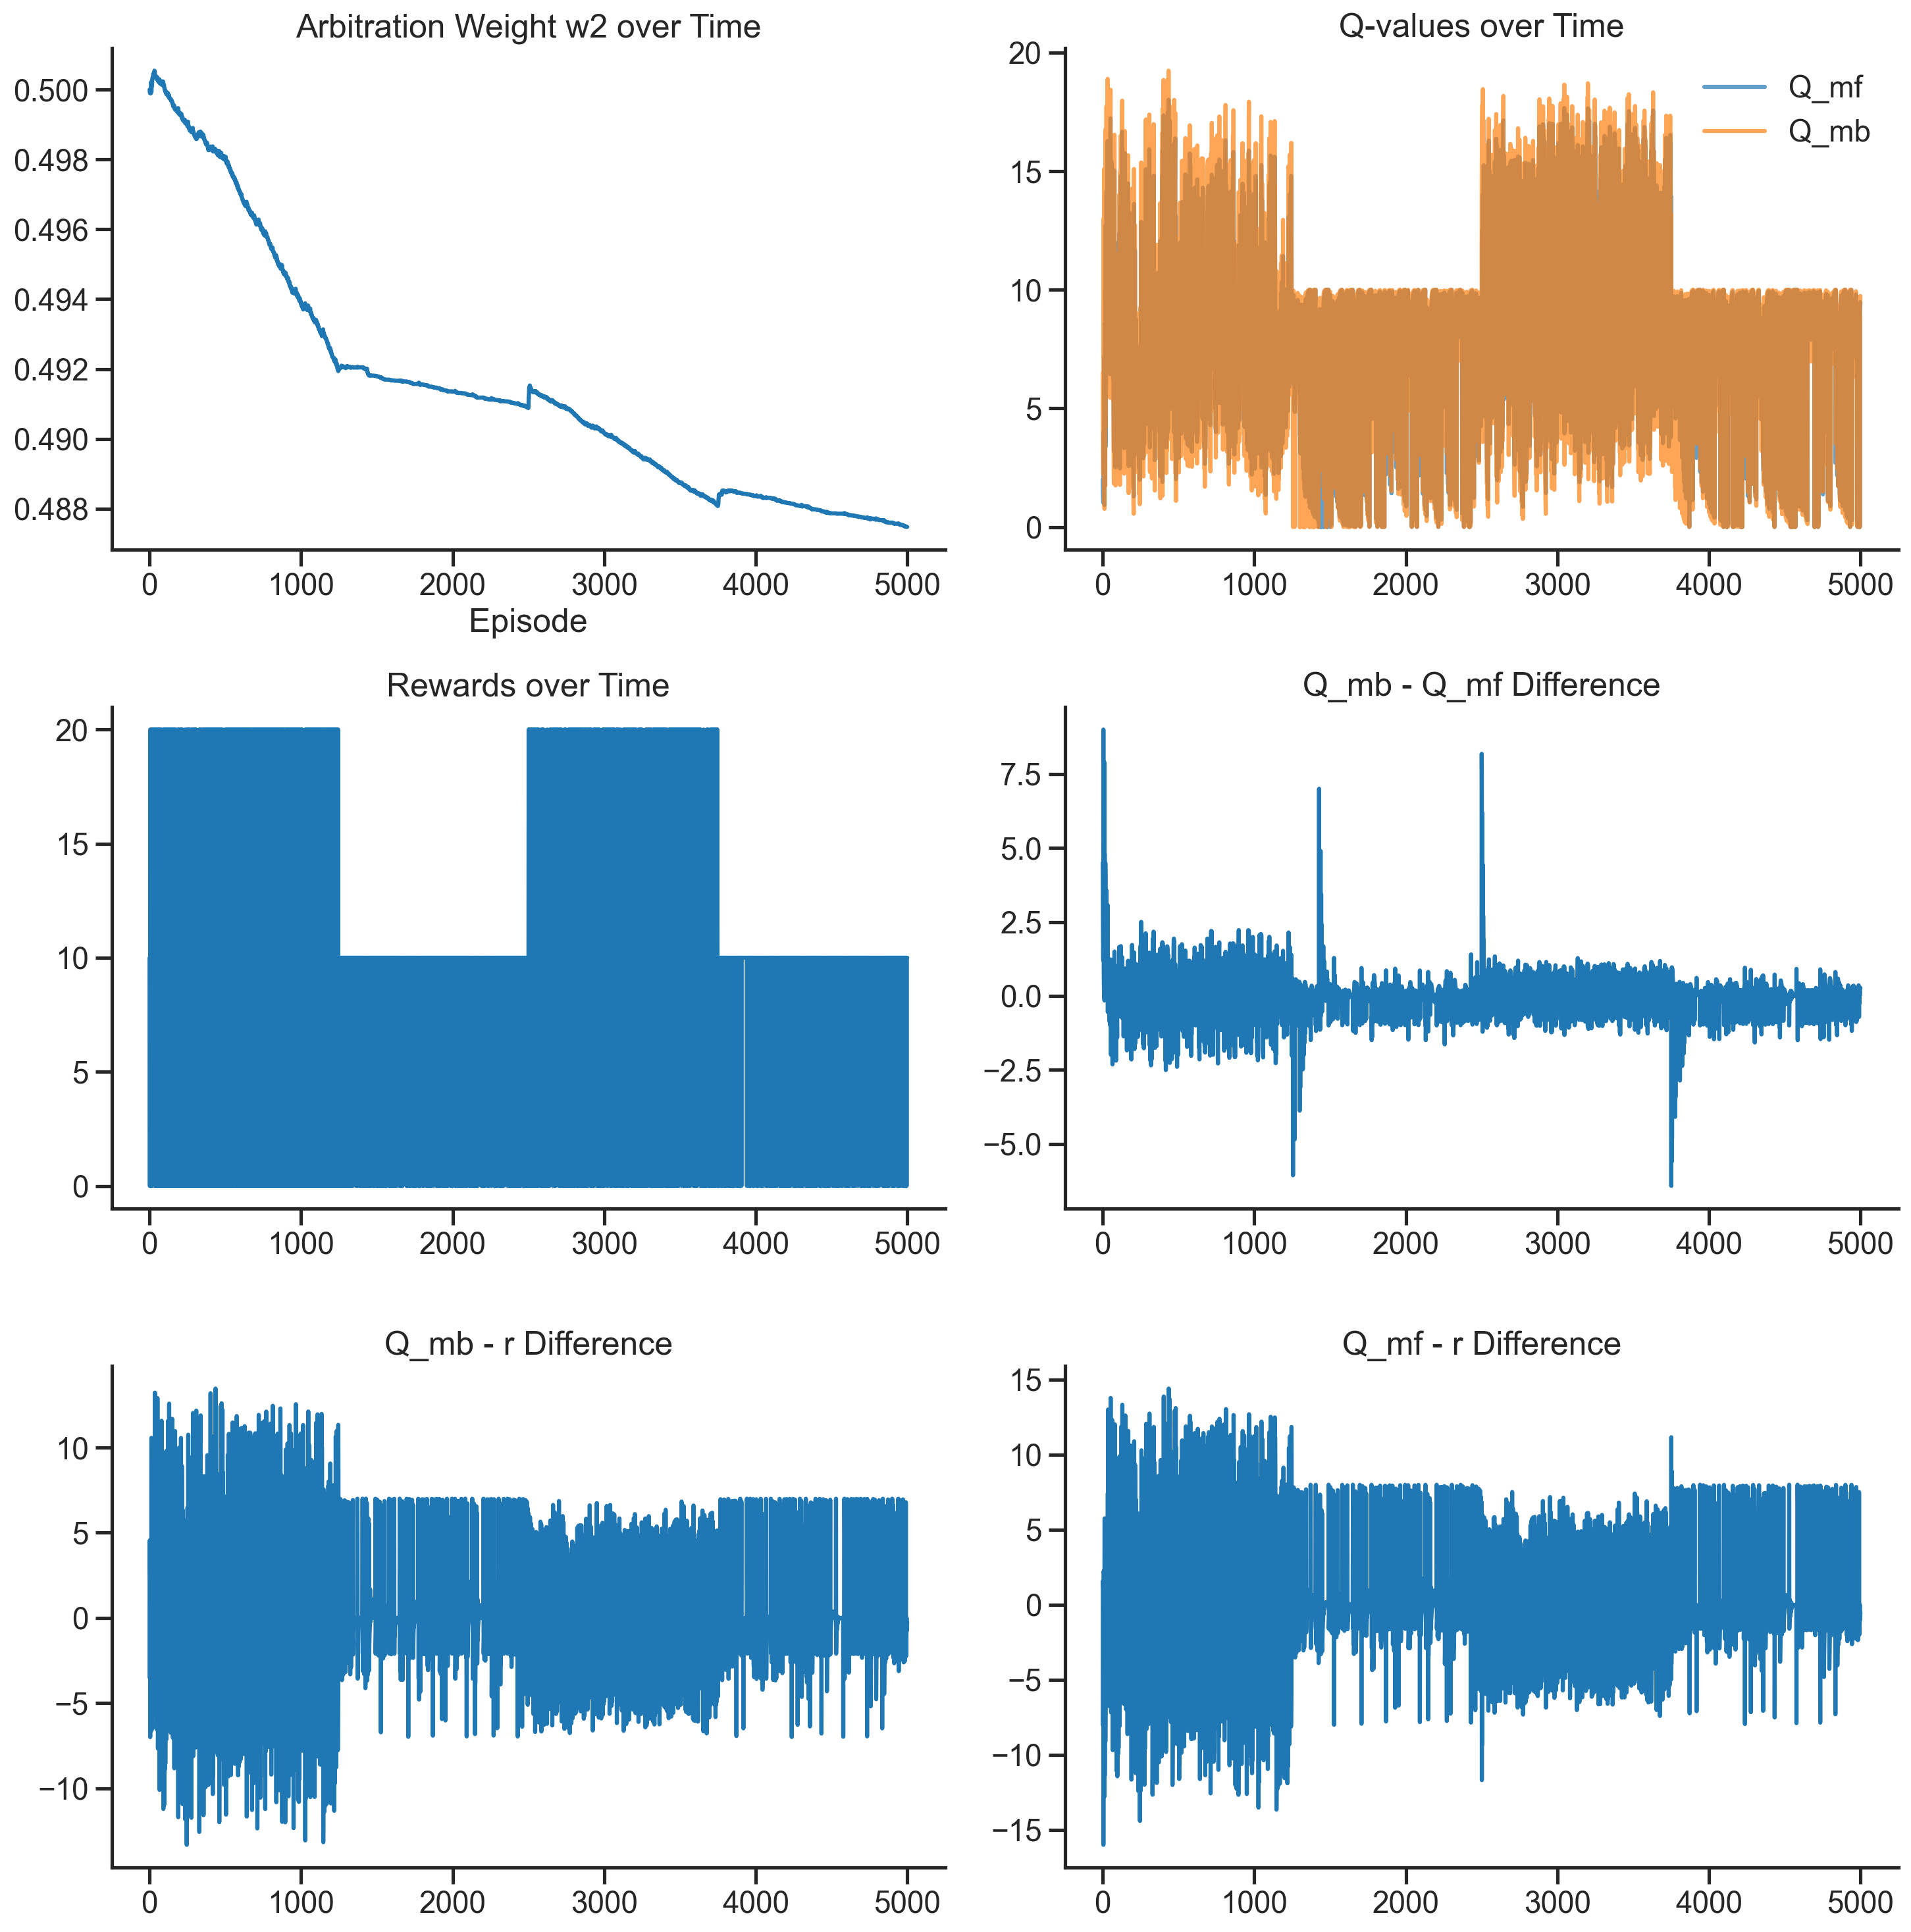

In [175]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot weights over time
axes[0,0].plot(sim_LA_data['w'])
axes[0,0].set_title('Arbitration Weight w2 over Time')
axes[0,0].set_xlabel('Episode')

# Plot Q-values
axes[0,1].plot(sim_LA_data['Q_mf'], label='Q_mf', alpha=0.7)
axes[0,1].plot(sim_LA_data['Q_mb'], label='Q_mb', alpha=0.7)
axes[0,1].set_title('Q-values over Time')
axes[0,1].legend()

# Plot rewards
axes[1,0].plot(sim_LA_data['r'])
axes[1,0].set_title('Rewards over Time')

# Plot difference between Q-values
q_diff = np.array(sim_LA_data['Q_mb']) - np.array(sim_LA_data['Q_mf'])
axes[1,1].plot(q_diff)
axes[1,1].set_title('Q_mb - Q_mf Difference')

# Plot Q_mb - r difference
qmb_minus_r = np.array(sim_LA_data['Q_mb']) - np.array(sim_LA_data['r'])
axes[2,0].plot(qmb_minus_r)
axes[2,0].set_title('Q_mb - r Difference')

# Plot Q_mf - r difference
qm_minus_r = np.array(sim_LA_data['Q_mf']) - np.array(sim_LA_data['r'])
axes[2,1].plot(qm_minus_r)
axes[2,1].set_title('Q_mf - r Difference')

plt.tight_layout()
plt.show()





In [176]:
sim_LA_df = pd.DataFrame(sim_LA_data)

sim_LA_df.to_excel("w-mf-mb-r.xlsx", index=False)